http://www.bigdataexaminer.com/dealing-with-unbalanced-classes-svm-random-forests-and-decision-trees-in-python/

In [19]:
from data_header import *
%matplotlib inline

In [12]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


In [13]:
Y = np.asarray([1 if v >= 7 else 0 for v in wine_df.quality.values])
wine_df = wine_df.drop('quality', axis=1)
wine_df.head()
X = wine_df.as_matrix()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

In [16]:
scores = list()
for val in range(1, 41):
    rfc = RandomForestClassifier(n_estimators=val)
    validated = cross_val_score(rfc, X, Y, cv=10)
    scores.append(validated)

40


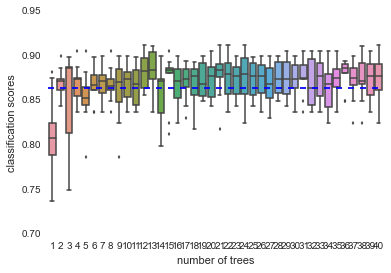

In [23]:
percentage = sum(Y == 0) / float(len(Y))
sns.boxplot(scores)
plt.axhline(y=percentage, ls='--')
plt.xlabel('number of trees')
plt.ylabel('classification scores')
plt.show()

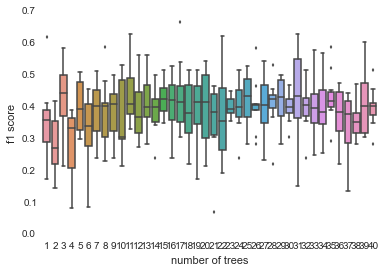

In [26]:
f1_scores = list()
for val in range(1, 41, 1):
    f1_scores.append(cross_val_score(RandomForestClassifier(n_estimators=val),
                                     X, Y, cv=10, scoring='f1'))
sns.boxplot(f1_scores)
plt.xlabel('number of trees')
plt.ylabel('f1 score')
plt.show()

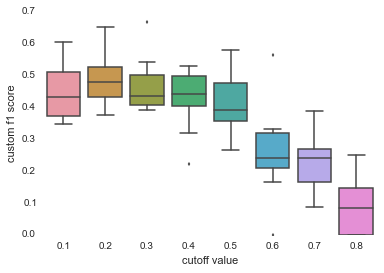

In [30]:
## setting the cutoff value for prediction

from sklearn.metrics import f1_score
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:, 1] > cutoff).astype(int)
def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return f1_score(y, ypred)
    return f1_cutoff
f1_scores_cutoff = list()
for cutoff in np.arange(0.1, 0.9, 0.1):
    rfc = RandomForestClassifier(n_estimators=15)
    f1_scores_cutoff.append(cross_val_score(rfc, X, Y, cv=10, 
                                            scoring=custom_f1(cutoff)))
sns.boxplot(f1_scores_cutoff, names=np.arange(0.1, 0.9, 0.1))
plt.xlabel('cutoff value')
plt.ylabel('custom f1 score')
plt.show()

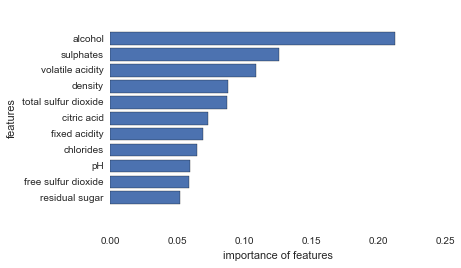

In [31]:
## feature importance

rfc = RandomForestClassifier(n_estimators=15)
rfc.fit(X, Y)
imp = rfc.feature_importances_
names = wine_df.columns
imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('importance of features')
plt.ylabel('features')
plt.show()

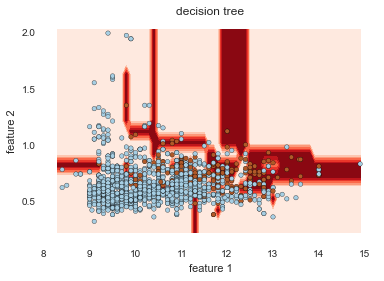

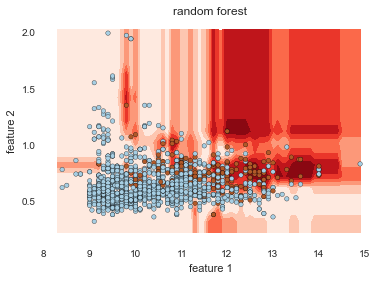

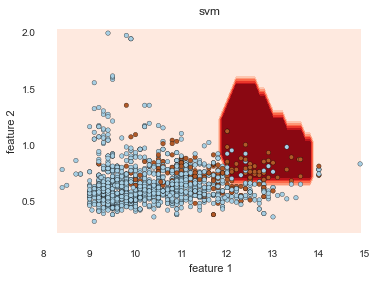

In [33]:
## decision surfaces

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def plot_decision_surface(clf, X_train, Y_train):
    plt_step = 0.1
    if X_train.shape[1] != 2:
        raise ValueError('X_train should have exactly 2 columns.')
    x_min, x_max = X_train[:, 0].min() - plt_step, X_train[:, 0].max() + plt_step
    y_min, y_max = X_train[:, 1].min() - plt_step, X_train[:, 1].max() + plt_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plt_step),
                         np.arange(y_min, y_max, plt_step))
    clf.fit(X_train, Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.Paired)
    plt.show()
    
imp_fe = np.argsort(imp)[::-1][0:2]
X_imp = X[:, imp_fe]
algorithms = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              SVC(C=100.0, gamma=1)]
title = ['decision tree', 'random forest', 'svm']
for i in range(3):
    plt.title(title[i])
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plot_decision_surface(algorithms[i], X_imp, Y)


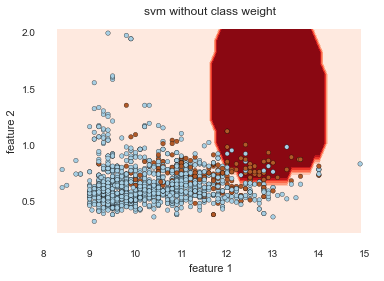

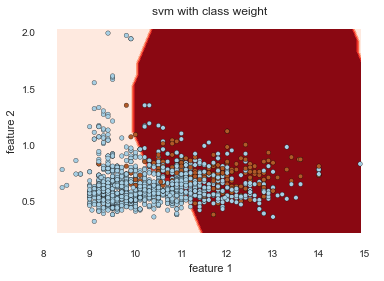

In [34]:
## class_weight in svm

svm = [SVC(C=1.0, gamma=1.0, class_weight=None),
       SVC(C=1.0, gamma=1.0, class_weight='auto')]
title = ['svm without class weight', 'svm with class weight']
for i in range(2):
    plt.title(title[i])
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plot_decision_surface(svm[i], X_imp, Y)